In [1]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import glob
import numpy as np
import pandas as pd
import functools
import os
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from itertools import product
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

%matplotlib inline
ia.seed(1)

In [28]:
def bb_midpoint_to_corner(bb):
    label = bb[0]
    x1 = bb[1] - bb[3]/2
    x2 = bb[1] + bb[3]/2
    y1 = bb[2] - bb[4]/2
    y2 = bb[2] + bb[4]/2
    corner_list = [label, x1, x2, y1, y2]
    return np.array(corner_list)

def bb_corner_to_midpoint(bb):
    label = bb[0]
    x = bb[1] + (bb[2] - bb[1])/2
    y = bb[3] + (bb[4] - bb[3])/2
    w = bb[2] - bb[1]
    h = bb[4] - bb[3]
    midpoint_list = [label, x, y, w, h]
    return np.array(midpoint_list)

def bbs_to_bb(bbs_list, width, height):
    try:
        corner_list = []
        for bbs in bbs_list:
            label = bbs.label
            x1 = bbs.x1/width
            x2 = bbs.x2/width
            y1 = bbs.y1/height
            y2 = bbs.y2/height
            corner_list.append([label, x1, x2, y1, y2])

        midpoint_list = np.apply_along_axis(bb_corner_to_midpoint, axis=1, arr=corner_list)
        return np.array(midpoint_list)
    except Exception as e:
        #print(e)
        return np.array([])

def save_bb_txt(bbs_df, name):
    bbs_df.to_csv(name, index = False, header = False, sep = " ", float_format='%.6f')

def open_yolo(image_name, label_path):
    try: 
        image = imageio.imread(image_name)
        shape = image.shape
        width = shape[1]
        height = shape[0]
        label = label_path + image_name.split("/")[-1].split(".")[0] + ".txt"
        boxes = np.genfromtxt(label, delimiter=' ')
        bb = boxes
        # reshaping the np array is necessary in case a file with a single box is read
        boxes = boxes.reshape(boxes.size//5, 5)
        #print(boxes.shape)
        boxes = np.apply_along_axis(bb_midpoint_to_corner, axis=1, arr=boxes)
        bbs = BoundingBoxesOnImage([BoundingBox(x1=list[1]*width, x2=list[2]*width, y1=list[3]*height, y2=list[4]*height, label = int(list[0])) for list in boxes], shape=image.shape)
        return image, bbs, bb
    except Exception as e:
        #print(e)
        return None, None

def calculate_position(index, factor):
    # since the crops are center aligned, the edges (0.0 and 1.0) can't use the same expression
    return 1 if index == 0 else 0 if index == (factor - 1) else (1 - index/factor) - 1/(factor*2)

def intersection(box1, box2):
    """
    This function calculates intersection given two
    bounding boxes.
    Parameters:
        box1 (dict): Predictions of Bounding Boxes
        box2 (dict): Correct labels of Bounding Boxes
    Returns:
        float: the area of the first box
        float: the area of the second box
        float: Intersection of the two boxes
    """
    box1_x1 = box1["x"] - box1["w"]/2
    box1_y1 = box1["y"] - box1["h"]/2
    box1_x2 = box1["x"] + box1["w"]/2
    box1_y2 = box1["y"] + box1["h"]/2
    box2_x1 = box2["x"] - box2["w"]/2
    box2_y1 = box2["y"] - box2["h"]/2
    box2_x2 = box2["x"] + box2["w"]/2
    box2_y2 = box2["y"] + box2["h"]/2

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    intersection = (x2 - x1) * (y2 - y1)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return box1_area, box2_area, intersection

def make_graph(bb_graph, image_name, graph_path):
    filename = graph_path + image_name.split("/")[-1].split(".")[0] + "_graph.png"
    plt.clf()
    pos = graphviz_layout(bb_graph)
    plt.axis('off')
    nx.draw_networkx_nodes(bb_graph,pos,node_color='g',alpha = 0.8)  # draws nodes
    nx.draw_networkx_edges(bb_graph,pos,edge_color='b',alpha = 0.6)  # draws edges
    nx.draw_networkx_edge_labels(bb_graph,pos,edge_labels = nx.get_edge_attributes(bb_graph,'weight')) # edge labels
    nx.draw_networkx_labels(bb_graph,pos) # node labels
    plt.savefig(filename, facecolor='gray')
    
def node_crop(bb_graph):
    # greedy answer: we will separate the connected subgraphs and get the node with most neighbors of each
    bb_subgraphs = (bb_graph.subgraph(c) for c in nx.connected_components(bb_graph))
    count = 0
    crops = []
    for sub in bb_subgraphs:
        print("Graph {}:".format(count))
        neighbors = {}
        for node in sub.nodes:
            print("Neighbors of {}: {}".format(node, [n for n in sub.neighbors(node)]))
            neighbors[node] = [n for n in sub.neighbors(node)]
        most_neighbors = max(len(item) for item in neighbors.values())
        popular_node = [index for index in neighbors if len(neighbors[index]) == most_neighbors][0]
        crops.append(sub.nodes[popular_node])
        print("Node {} is the most popular, with {} neighbors.".format(popular_node, most_neighbors))
        print("Node coordinates: " + str(sub.nodes[popular_node]))
        
        # if the subgraph is bigger than 3 nodes we also want to find the most isolated one
        if(len(neighbors) > 3):
            least_neighbors = min(len(item) for item in neighbors.values())
            poor_node = [index for index in neighbors if len(neighbors[index]) == least_neighbors][0]
            crops.append(sub.nodes[poor_node])
            print("Node {} is the least popular, with {} neighbors. Isn't that sad?".format(poor_node, least_neighbors))
            print("Node coordinates: " + str(sub.nodes[poor_node]))

        count+=1

    #print(crops)
    return crops
    
def normalize_position(pos_arg, factor):
    # the crops are center aligned
    return index/factor

In [3]:
image_path = "../yolo-station/images_bgr/"
label_path = "../yolo-station/labels_sub/"
graph_path = "./crop_graphs/"

image_list = os.path.join(os.path.join(image_path, "*.*"))
label_list = []

image_list = glob.glob(image_list)
for name in image_list:
    label_list.append(label_path + name.split("/")[-1].split(".")[0] + ".txt")


Graph 0:
Neighbors of 0: [2]
Neighbors of 1: [4, 10, 11]
Neighbors of 2: [0, 10, 11]
Neighbors of 4: [1, 6]
Neighbors of 5: [6, 7, 8]
Neighbors of 6: [4, 5, 7, 8, 9, 10, 11]
Neighbors of 7: [5, 6, 8, 9, 10, 11]
Neighbors of 8: [5, 6, 7, 9, 10, 11]
Neighbors of 9: [6, 7, 8, 10, 11]
Neighbors of 10: [1, 2, 6, 7, 8, 9, 11]
Neighbors of 11: [1, 2, 7, 8, 9, 10, 6]
Node 6 is the most popular, with 7 neighbors.
Node coordinates: {'x': 832, 'y': 519, 'w': 65, 'h': 124}
Node 0 is the least popular, with 1 neighbors. Isn't that sad?
Node coordinates: {'x': 1139, 'y': 813, 'w': 281, 'h': 217}
Graph 1:
Neighbors of 3: []
Node 3 is the most popular, with 0 neighbors.
Node coordinates: {'x': 1230, 'y': 376, 'w': 100, 'h': 187}
Number of images with boxes: 1
Number of cropped images: 3


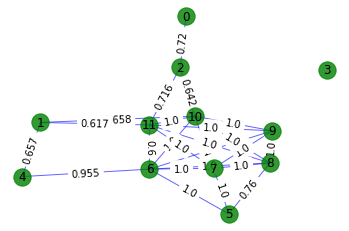

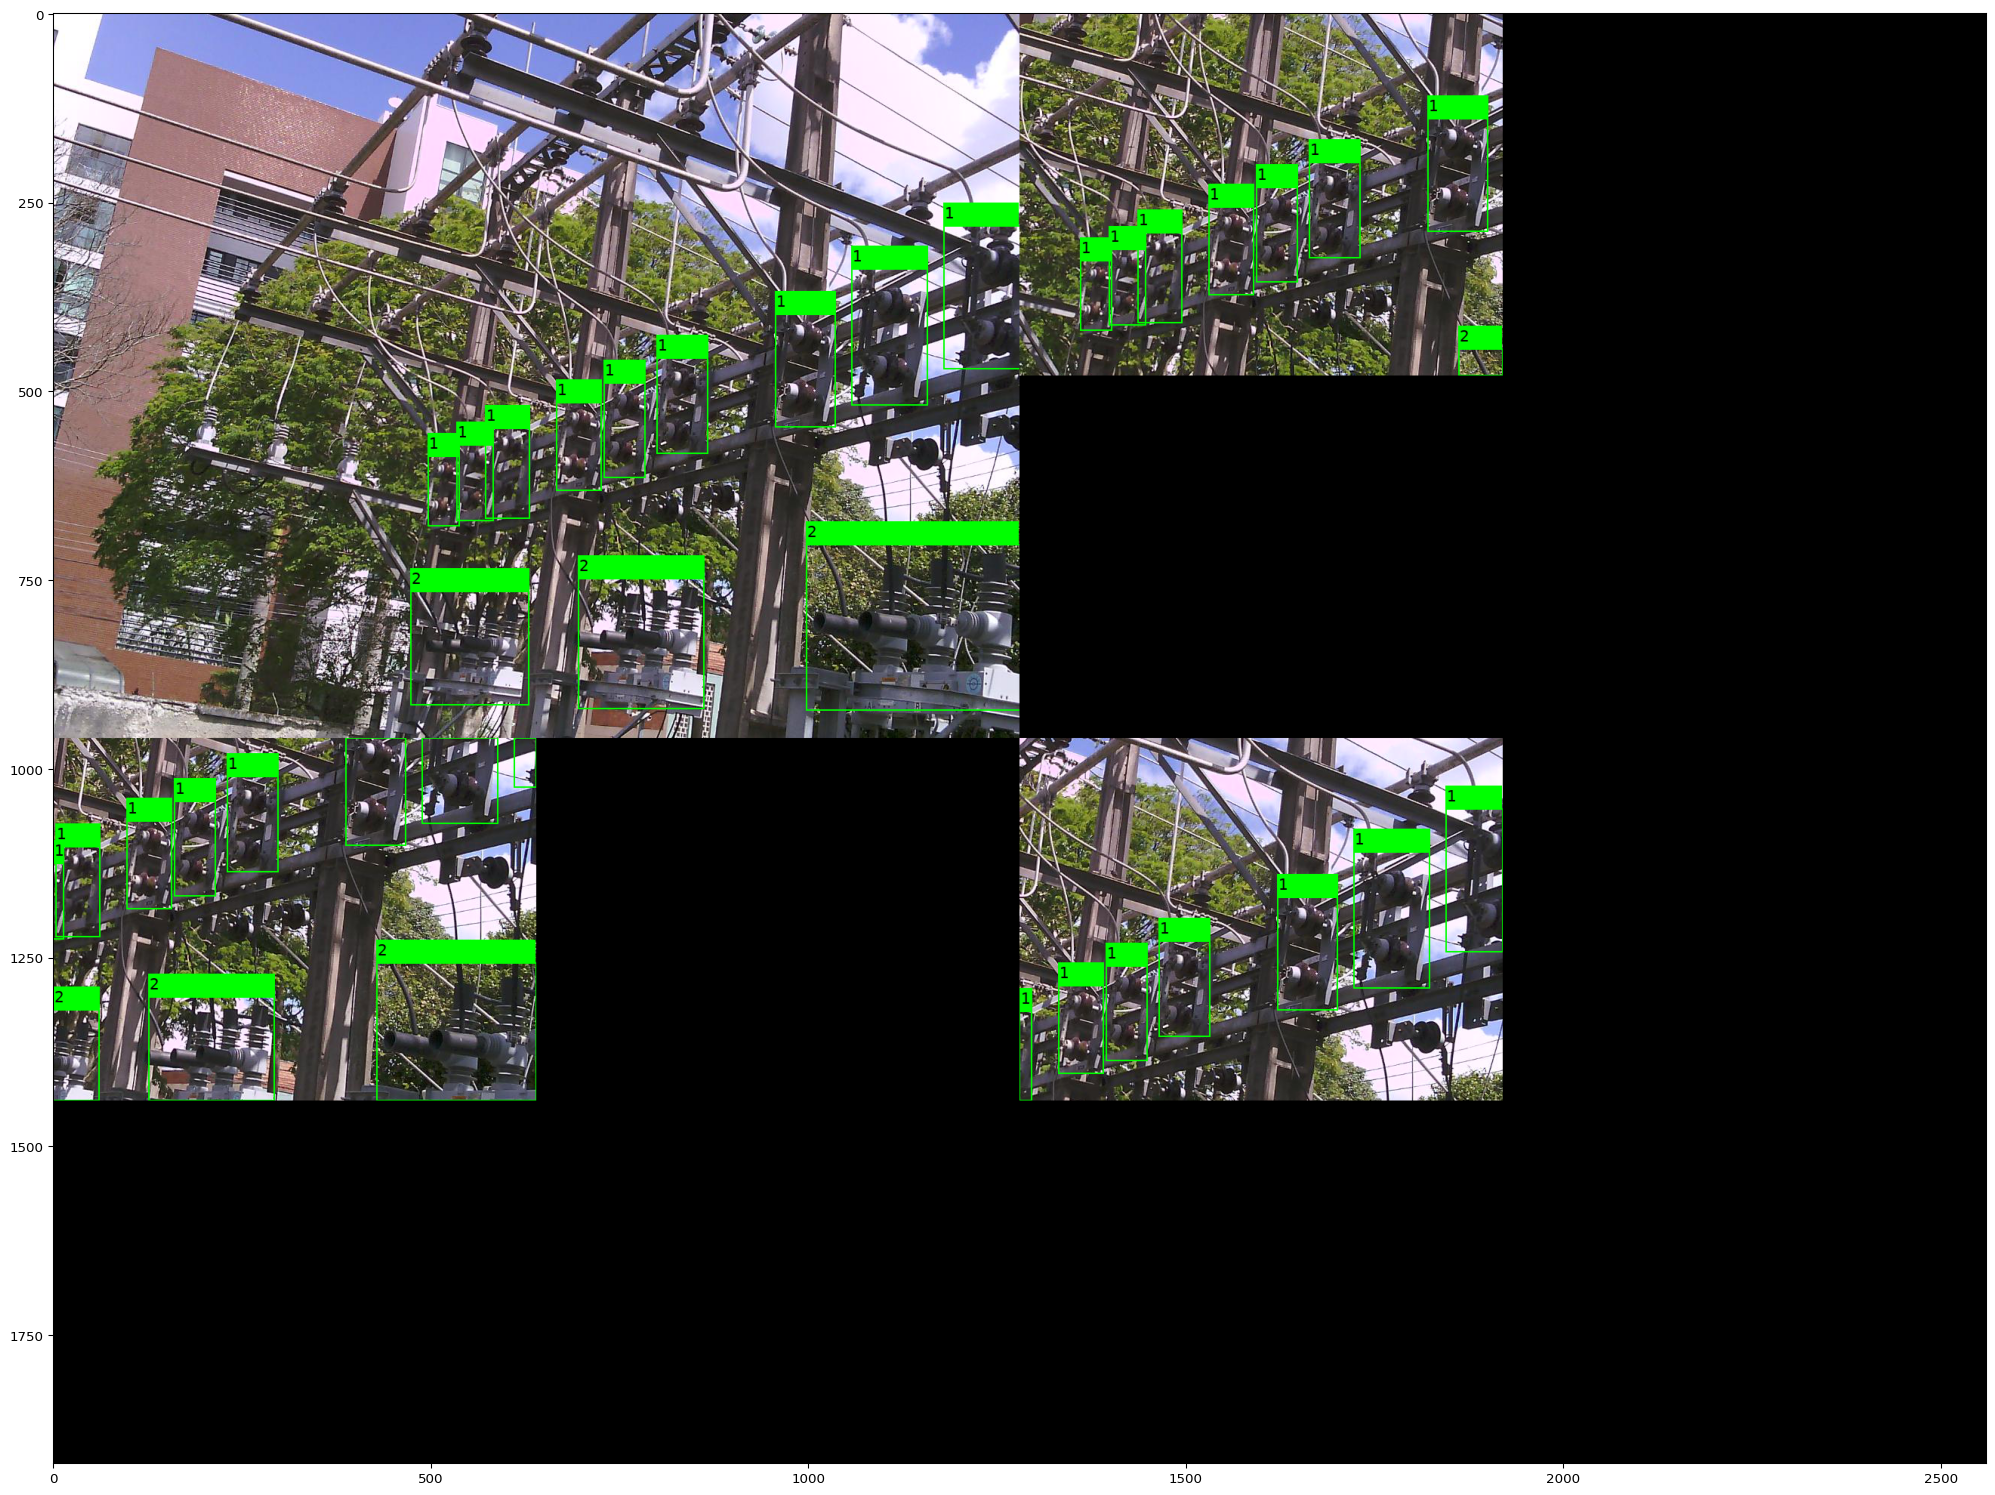

In [29]:
for im in image_list[3:4]:
    image_count = 0
    image_name = im
    #print(image_name)
    image, bbs, bb = open_yolo(image_name, label_path)
    shape = image.shape
    width = shape[1]
    height = shape[0]
    h_factor = 480
    w_factor = 640    
    bb_graph = nx.Graph()
    count = 0
    # makes a graph out of the bounding boxes in the image, where each node is a bb
    for box in bb:
        x = int(box[1] * width)
        y = int(box[2] * height)
        w = int(box[3] * width)
        h = int(box[4] * height)
        bb_graph.add_node(count, x = x, y = y, w = w, h = h)
        count +=1
    #print(bb_graph.nodes.data())

    # uses intersection to determine the edges between the nodes
    for j, i in product(bb_graph.nodes, bb_graph.nodes):
        if(i != j):
            x = bb_graph.nodes[i]["x"]
            y = bb_graph.nodes[i]["y"]
            if(x + w_factor//2 > width):
                x = x - (width - w_factor//2)
            elif(x - w_factor//2 < 0):
                x = x + abs(w_factor//2 - x)
            if(y + h_factor//2 > height):
                y = y - (height - h_factor//2)
            elif(y - h_factor//2 < 0):
                y = y + abs(h_factor//2 - y)
            area1, area2, inter = intersection({
                                        "x": x, 
                                        "y": y,
                                        "w": w_factor,
                                        "h": h_factor
                                        },
                                        bb_graph.nodes[j])
            # we only care if the candidate box j is at least 60% inside the crop window
            if(area2*0.6 <= inter <= area2):
                bb_graph.add_edge(i,j)
                #print(inter, area2)
                # the weight is the ratio between the intersection and the area of the inner box
                bb_graph[i][j]['weight'] = round(inter/area2, 3)
                #print(inter/area2)
    
    # makes the graph to show the connectivity of the nodes and saves it
    make_graph(bb_graph, image_name, graph_path)

    # gets the coordinates of which nodes we will crop around
    crops = node_crop(bb_graph)
    augmented_count = 0
    count = 0

    # remove later, for showing only
    draw_vec = []
    draw_vec.append(bbs.draw_on_image(image, size=2))

    for c in crops:
        # position tuple: left-right, low-high ranging from 0.0 to 1.0
        x = calculate_position(c["x"], width)
        y = calculate_position(c["y"], height)
        seq = iaa.Sequential([iaa.CropToFixedSize(width=w_factor, height=h_factor, position=(x, y)),
                              ])
        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()

        # remove later, for showing only
        draw_vec.append(bbs_aug.draw_on_image(image_aug, size=2))

        bb = bbs_to_bb(bbs_aug, w_factor, h_factor)

        aug_name = image_name.split("/")[-1].split(".")[0]
        # saving the image
        imageio.imwrite("./crop_images/" + aug_name + "_crop_" + str(count) + ".jpg", image_aug)            
        #print(aug_name + "_aug_" + str(count))
        # saving the YOLO bb file
        df_bb = pd.DataFrame(bb, columns = ["label", "x", "y", "w", "h"])
        df_bb["label"] = df_bb["label"].astype(int)
        save_bb_txt(df_bb, "./crop_labels/" + aug_name + "_crop_" + str(count) + ".txt")
        augmented_count += 1
        count += 1

    image_count += 1
    print("Number of images with boxes: {}".format(image_count))
    print("Number of cropped images: {}".format(augmented_count))

    ia.ia.show_grid(draw_vec, rows=None, cols=None)
        

    

In [258]:
neighbors = {}
for node in bb_graph.nodes:
    neighbors[node] = [n for n in bb_graph.neighbors(node)]

most_neighbors = max(len(item) for item in neighbors.values())
print(most_neighbors)
popular_node = [index for index in neighbors if len(neighbors[index]) == most_neighbors][0]
accounted_nodes = []
accounted_nodes.append(popular_node)
for n in neighbors[popular_node]:
    accounted_nodes.append(n)
print("Node {} with neighbors {}.".format(popular_node, neighbors[popular_node]))
print(accounted_nodes)


5
Node 6 with neighbors [3, 4, 5, 0, 7].
[6, 3, 4, 5, 0, 7]


In [166]:
cliques = [n for n in nx.find_cliques(bb_graph)]
print(cliques)

big_clique = max(len(c) for c in cliques)
big_clique = max(cliques, key=len)
big_clique_crop = 
big_clique = cliques.remove(big_clique)
print(cliques)
print(big_clique)


[[1, 2], [6, 0, 3], [6, 0, 7], [6, 4, 3], [6, 4, 5], [6, 4, 7]]
[[1, 2], [6, 0, 3], [6, 0, 7], [6, 4, 5], [6, 4, 7]]
[6, 4, 3]


{0: Text(27.0, 28.639, '0'),
 1: Text(117.0, 73.639, '1'),
 2: Text(188.21, 63.0, '2'),
 5: Text(45.0, 99.0, '5'),
 7: Text(98.21, 18.0, '7')}

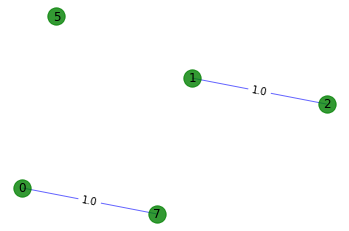

In [172]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

pos = graphviz_layout(bb_graph)
plt.axis('off')
nx.draw_networkx_nodes(bb_graph,pos,node_color='g',alpha = 0.8)  # draws nodes
nx.draw_networkx_edges(bb_graph,pos,edge_color='b',alpha = 0.6)  # draws edges
nx.draw_networkx_edge_labels(bb_graph,pos,edge_labels = nx.get_edge_attributes(bb_graph,'weight')) # edge lables
nx.draw_networkx_labels(bb_graph,pos) # node lables